# Fifa19 Project
In the following project we will build 2 models, using supervised learning and unsupervised learning using the dataset of fifa19 from kaggle.

*   Model 1 - unsupervised learning: Data preprocessing, PCA, K-Means.
*   Model 2 - supervised learning: Data preprocessing, SVM and Artificial Neural Network (ANN)



## Load Data

In [0]:
# load packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import files

In [0]:
upload_file = files.upload()

Saving fifa19.csv to fifa19.csv


In [0]:
fifa = pd.read_csv('fifa19.csv')

In [0]:
fifa.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,...,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,Yes,RF,10.0,"Jul 1, 2004",NaN,2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,...,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,Yes,ST,7.0,"Jul 10, 2018",NaN,2022,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,...,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,Yes,LW,10.0,"Aug 3, 2017",NaN,2022,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,...,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,€72M,€260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,Yes,GK,1.0,"Jul 1, 2011",NaN,2020,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,Normal,Yes,RCM,7.0,"Aug 30, 2015",NaN,2023,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,...,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


#### EDA

In [0]:
fifa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 89 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                18207 non-null  int64  
 1   ID                        18207 non-null  int64  
 2   Name                      18207 non-null  object 
 3   Age                       18207 non-null  int64  
 4   Photo                     18207 non-null  object 
 5   Nationality               18207 non-null  object 
 6   Flag                      18207 non-null  object 
 7   Overall                   18207 non-null  int64  
 8   Potential                 18207 non-null  int64  
 9   Club                      17966 non-null  object 
 10  Club Logo                 18207 non-null  object 
 11  Value                     18207 non-null  object 
 12  Wage                      18207 non-null  object 
 13  Special                   18207 non-null  int64  
 14  Prefer

In [0]:
fifa.describe()

,Unnamed: 0,ID,Age,Overall,Potential,Special,International Reputation,Weak Foot,Skill Moves,Jersey Number,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
count,18207.000000,18207.000000,18207.000000,18207.000000,18207.000000,18207.000000,18159.000000,18159.000000,18159.000000,18147.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000
mean,9103.000000,214298.338606,25.122206,66.238699,71.307299,1597.809908,1.113222,2.947299,2.361308,19.546096,49.734181,45.550911,52.298144,58.686712,42.909026,55.371001,47.170824,42.863153,52.711933,58.369459,64.614076,64.726967,63.503607,61.836610,63.966573,55.460047,65.089432,63.219946,65.311967,47.109973,55.868991,46.698276,49.958478,53.400903,48.548598,58.648274,47.281623,47.697836,45.661435,16.616223,16.391596,16.232061,16.388898,16.710887
std,5256.052511,29965.244204,4.669943,6.908930,6.136496,272.586016,0.394031,0.660456,0.756164,15.947765,18.364524,19.525820,17.379909,14.699495,17.694408,18.910371,18.395264,17.478763,15.327870,16.686595,14.927780,14.649953,14.766049,9.010464,14.136166,17.237958,11.820044,15.894741,12.557000,19.260524,17.367967,20.696909,19.529036,14.146881,15.704053,11.436133,19.904397,21.664004,21.289135,17.695349,16.906900,16.502864,17.034669,17.955119
min,0.000000,16.000000,16.000000,46.000000,48.000000,731.000000,1.000000,1.000000,1.000000,1.000000,5.000000,2.000000,4.000000,7.000000,4.000000,4.000000,6.000000,3.000000,9.000000,5.000000,12.000000,12.000000,14.000000,21.000000,16.000000,2.000000,15.000000,12.000000,17.000000,3.000000,11.000000,3.000000,2.000000,10.000000,5.000000,3.000000,3.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4551.500000,200315.500000,21.000000,62.000000,67.000000,1457.000000,1.000000,3.000000,2.000000,8.000000,38.000000,30.000000,44.000000,54.000000,30.000000,49.000000,34.000000,31.000000,43.000000,54.000000,57.000000,57.000000,55.000000,56.000000,56.000000,45.000000,58.000000,56.000000,58.000000,33.000000,44.000000,26.000000,38.000000,44.000000,39.000000,51.000000,30.000000,27.000000,24.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,9103.000000,221759.000000,25.000000,66.000000,71.000000,1635.000000,1.000000,3.000000,2.000000,17.000000,54.000000,49.000000,56.000000,62.000000,44.000000,61.000000,48.000000,41.000000,56.000000,63.000000,67.000000,67.000000,66.000000,62.000000,66.000000,59.000000,66.000000,66.000000,67.000000,51.000000,59.000000,52.000000,55.000000,55.000000,49.000000,60.000000,53.000000,55.000000,52.000000,11.000000,11.000000,11.000000,11.000000,11.000000
75%,13654.500000,236529.500000,28.000000,71.000000,75.000000,1787.000000,1.000000,3.000000,3.000000,26.000000,64.000000,62.000000,64.000000,68.000000,57.000000,68.000000,62.000000,57.000000,64.000000,69.000000,75.000000,75.000000,74.000000,68.000000,74.000000,68.000000,73.000000,74.000000,74.000000,62.000000,69.000000,64.000000,64.000000,64.000000,60.000000,67.000000,64.000000,66.000000,64.000000,14.000000,14.000000,14.000000,14.000000,14.000000
max,18206.000000,246620.000000,45.000000,94.000000,95.000000,2346.000000,5.000000,5.000000,5.000000,99.000000,93.000000,95.000000,94.000000,93.000000,90.000000,97.000000,94.000000,94.000000,93.000000,96.000000,97.000000,96.000000,96.000000,96.000000,96.000000,95.000000,95.000000,96.000000,97.000000,94.000

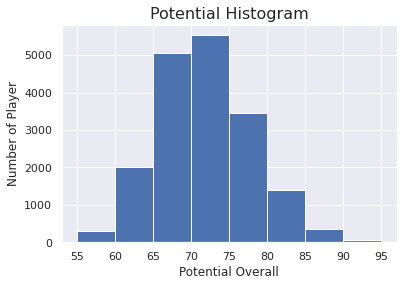

In [0]:
plt.hist(fifa['Potential'], bins = range(55,100,5))
plt.title('Potential Histogram', fontdict={'fontsize': 16})
plt.ylabel('Number of Player')
plt.xlabel('Potential Overall')
plt.show()

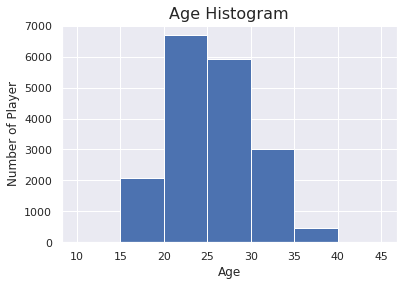

In [0]:
plt.hist(fifa['Age'], bins = range(10,50,5))
plt.title('Age Histogram', fontdict={'fontsize': 16})
plt.ylabel('Number of Player')
plt.xlabel('Age')
plt.show()

###### players positions

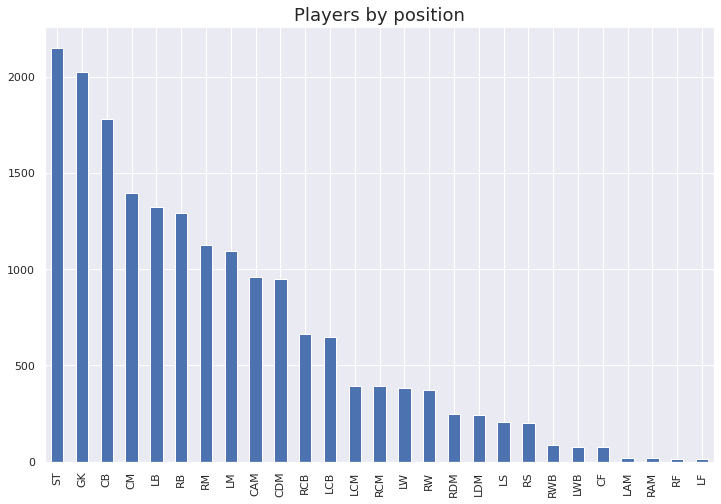

In [0]:
plt.figure(figsize=(12,8))
fifa['Position'].value_counts().plot(kind='bar')
plt.title('Players by position', fontdict={'fontsize': 18})
plt.show()

In [0]:
best_players = fifa.loc[fifa['Overall']>=80]

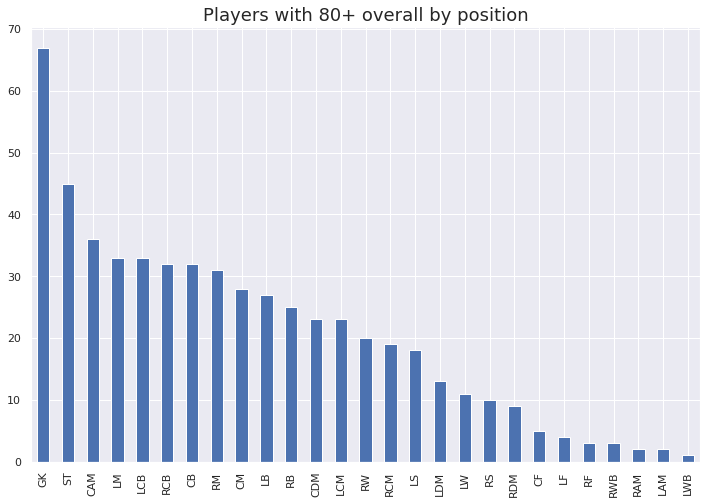

In [0]:
plt.figure(figsize=(12,8))
best_players['Position'].value_counts().plot(kind='bar')
plt.title('Players with 80+ overall by position', fontdict={'fontsize': 18})
plt.show()

In [0]:
best = best_players.groupby(['Position'])['Overall'].count()
df_best = pd.DataFrame(best)

In [0]:
df_best = df_best.reset_index()

In [0]:
all_players = fifa.groupby(['Position'])['Overall'].count()
df_all = pd.DataFrame(all_players)

In [0]:
df_all = df_all.reset_index()

In [0]:
df_all_sorted = df_all.sort_values(by=['Position'])
df_best_sorted = df_best.sort_values(by=['Position'])

In [0]:
df_positions_merged = pd.concat([df_all_sorted, df_best_sorted], axis=1)
df_positions_merged.columns = ['Position', 'All', 'Delete', 'Best']

In [0]:
df_positions_merged = df_positions_merged.drop(labels=['Delete'], axis=1)

In [0]:
df_positions_merged['Pct'] = (df_positions_merged['Best'] / df_positions_merged['All']) * 100

In [0]:
df_positions_merged = df_positions_merged.sort_values(by=['Pct'], ascending=False)

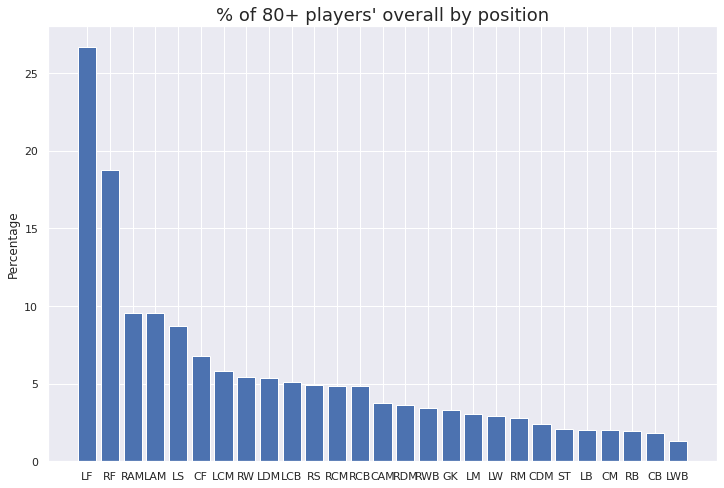

In [0]:
plt.figure(figsize=(12,8))
plt.bar(df_positions_merged['Position'], df_positions_merged['Pct'])
plt.title("% of 80+ players' overall by position", fontdict={'fontsize': 18})
plt.ylabel("Percentage")
plt.show()

###### Preffered foot

In [0]:
preffered_foot = fifa.groupby(['Preferred Foot'])['Overall'].count()
preffered_foot

Preferred Foot
Left      4211
Right    13948
Name: Overall, dtype: int64

In [0]:
preffered_foot_keys = fifa.groupby(['Preferred Foot'])['Overall'].groups.keys() 
preffered_foot_values = preffered_foot.tolist()

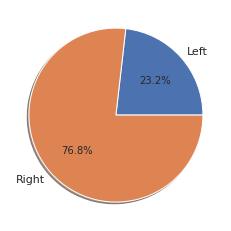

In [0]:
plt.pie(preffered_foot_values, labels=preffered_foot_keys, autopct='%1.1f%%', shadow=True)
plt.show()

# Model 1: Unsuperised Learning

using unsupervised learning, find positions clusters (attack, goalkeeper, defense, middlefield) baserd only on their skills

## Prepare Data 

### Map Real Positions to Real Classes (i.e. areas in the fields: attack, midfield, defence and goalkeeper)


In [0]:
valid_data =  fifa[:13236]

In [0]:
valid_data['Position'].unique()

array(['RF', 'ST', 'LW', 'GK', 'RCM', 'LF', 'RS', 'RCB', 'LCM', 'CB',
       'LDM', 'CAM', 'CDM', 'LS', 'LCB', 'RM', 'LAM', 'LM', 'LB', 'RDM',
       'RW', 'CM', 'RB', 'RAM', 'CF', 'RWB', 'LWB', nan], dtype=object)

In [0]:
# check for nan values
valid_data['Position'].loc[valid_data['Position'].isna()]

5018     NaN
6736     NaN
7922     NaN
9905     NaN
10628    NaN
Name: Position, dtype: object

In [0]:
# Remove nan values. could use as well dropna method
valid_data = valid_data.drop([5018,6736,7922,9905,10628], axis=0)

In [0]:
# map
Pos_to_class = {'RF': 'Attack', 'ST': 'Attack', 'LW': 'Attack', 'LF': 'Attack', 'RS': 'Attack', 'CAM': 'Attack', 'LS': 'Attack', 'LAM': 'Attack', 'RW': 'Attack', 'RAM': 'Attack', 'CF': 'Attack',
               'GK': 'Goalkeeper',
               'RCM': 'Midfield', 'LCM': 'Midfield', 'LDM': 'Midfield', 'CDM': 'Midfield', 'RM': 'Midfield', 'LM': 'Midfield', 'RDM': 'Midfield', 'CM': 'Midfield', 'RWB': 'Midfield', 'LWB': 'Midfield',
               'RCB': 'Defence', 'CB': 'Defence', 'LCB': 'Defence', 'LB': 'Defence', 'RB': 'Defence'}

In [0]:
valid_data['Real Class'] = valid_data['Position'].map(Pos_to_class)

#### Define X

In [0]:
X = fifa.iloc[:13236,54:88]

In [0]:
X.shape

(13236, 34)

In [0]:
X.head()

,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


## Scale 

In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
sc = StandardScaler()

In [0]:
X_sc = sc.fit_transform(X)

## PCA

In [0]:
# PCA - known number of components
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_sc)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [0]:
# PCA - see results
print("explained_variance_ratio_: \nshows what percentage each parameter explains")
print(np.round(pca.explained_variance_ratio_,3))

print("\ncommulative sum:")
print(np.cumsum(np.round(pca.explained_variance_ratio_,3)))

explained_variance_ratio_: 
shows what percentage each parameter explains
[0.527 0.163]

commulative sum:
[0.527 0.69 ]


### KMeans

In [0]:
from sklearn.cluster import KMeans

In [0]:
k_means = KMeans(n_clusters=4)

In [0]:
k_means.fit(X_sc)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
pca2 = pca.transform(X_sc)

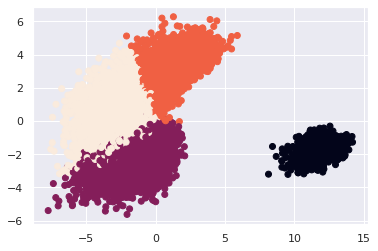

In [0]:
plt.scatter(pca2[:, 0], pca2[:, 1], c=k_means.labels_)
plt.show()

In [0]:
k_means.labels_[0:10]

array([1, 1, 1, 0, 3, 1, 3, 3, 3, 0], dtype=int32)

#### Check results

In [0]:
def position(n):
    pos = ""
    name = fifa['Name'][n]
        
    if k_means.labels_[n] == 0:
        pos = "Goalkeeper"
    elif k_means.labels_[n] == 1:
        pos = "Attack"
    elif k_means.labels_[n] == 2:
        pos = "Defence"
    else:
        pos = "Midfield"
    print(name + ": " + pos)

In [0]:
for n in range(0,50):
    position(n)

L. Messi: Attack
Cristiano Ronaldo: Attack
Neymar Jr: Attack
De Gea: Goalkeeper
K. De Bruyne: Midfield
E. Hazard: Attack
L. Modrić: Midfield
L. Suárez: Midfield
Sergio Ramos: Midfield
J. Oblak: Goalkeeper
R. Lewandowski: Attack
T. Kroos: Midfield
D. Godín: Midfield
David Silva: Midfield
N. Kanté: Midfield
P. Dybala: Attack
H. Kane: Midfield
A. Griezmann: Midfield
M. ter Stegen: Goalkeeper
T. Courtois: Goalkeeper
Sergio Busquets: Midfield
E. Cavani: Midfield
M. Neuer: Goalkeeper
S. Agüero: Attack
G. Chiellini: Defence
K. Mbappé: Attack
M. Salah: Midfield
Casemiro: Midfield
J. Rodríguez: Midfield
L. Insigne: Attack
Isco: Midfield
C. Eriksen: Midfield
Coutinho: Midfield
P. Aubameyang: Attack
M. Hummels: Midfield
Marcelo: Midfield
G. Bale: Midfield
H. Lloris: Goalkeeper
G. Higuaín: Attack
Thiago Silva: Midfield
S. Handanovič: Goalkeeper
G. Buffon: Goalkeeper
S. Umtiti: Midfield
M. Icardi: Attack
K. Koulibaly: Defence
P. Pogba: Midfield
K. Navas: Goalkeeper
R. Lukaku: Attack
C. Immobile: At

## KPCA

In [0]:
from sklearn.decomposition import KernelPCA

### KMeans - choose best gamma

In [0]:
# KPCA Option 1
kpca = KernelPCA(kernel='rbf', n_components=2, fit_inverse_transform=True)
X_sc_kpca = kpca.fit_transform(X_sc)

In [0]:
k_means2 = KMeans(n_clusters=4)
k_means2.fit(X_sc_kpca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
# KPCA Option 2
kpca_001 = KernelPCA(kernel='rbf', n_components=2, fit_inverse_transform=True, gamma = 0.01)
X_sc_kpca001 = kpca_001.fit_transform(X_sc)

In [0]:
k_means2_001 = KMeans(n_clusters=4)
k_means2_001.fit(X_sc_kpca001)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
# KPCA Option 3
kpca_01 = KernelPCA(kernel='rbf', n_components=2, fit_inverse_transform=True, gamma = 0.1)
X_sc_kpca01 = kpca_01.fit_transform(X_sc)

In [0]:
k_means2_01 = KMeans(n_clusters=4)
k_means2_01.fit(X_sc_kpca01)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
# KPCA Option 4
kpca_1 = KernelPCA(kernel='rbf', n_components=2, fit_inverse_transform=True, gamma = 1)
X_sc_kpca1 = kpca_1.fit_transform(X_sc)

In [0]:
k_means2_1 = KMeans(n_clusters=4)
k_means2_1.fit(X_sc_kpca1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
# KPCA Option 5
kpca_10 = KernelPCA(kernel='rbf', n_components=2, fit_inverse_transform=True, gamma = 10)
X_sc_kpca10 = kpca_10.fit_transform(X_sc)

In [0]:
k_means2_10 =KMeans(n_clusters=4)
k_means2_10.fit(X_sc_kpca10)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

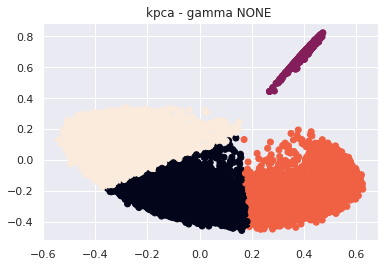

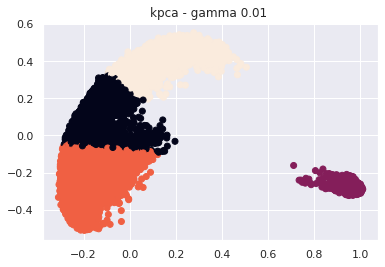

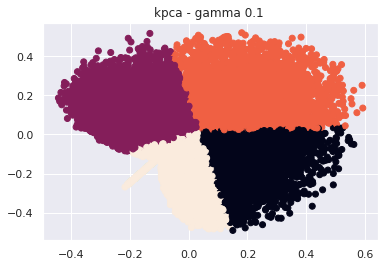

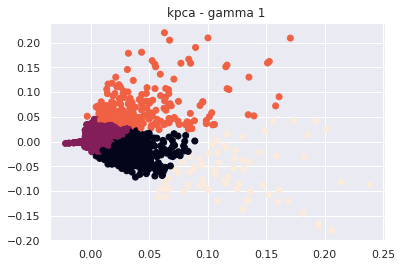

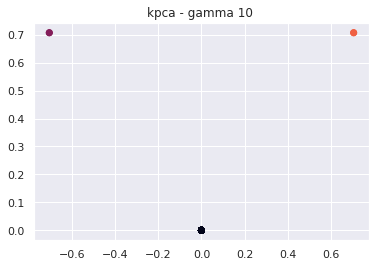

In [0]:
plt.title("kpca - gamma NONE ")
plt.scatter(X_sc_kpca[:, 0], X_sc_kpca[:, 1], c=k_means2.labels_)
plt.show()

plt.title("kpca - gamma 0.01 ")
plt.scatter(X_sc_kpca001[:, 0], X_sc_kpca001[:, 1], c=k_means2_001.labels_)
plt.show()

plt.title("kpca - gamma 0.1 ")
plt.scatter(X_sc_kpca01[:, 0], X_sc_kpca01[:, 1], c=k_means2_01.labels_)
plt.show()

plt.title("kpca - gamma 1 ")
plt.scatter(X_sc_kpca1[:, 0], X_sc_kpca1[:, 1], c=k_means2_1.labels_)
plt.show()

plt.title("kpca - gamma 10 ")
plt.scatter(X_sc_kpca10[:, 0], X_sc_kpca10[:, 1], c=k_means2_10.labels_)
plt.show()

gamma 0.01 looks best

In [0]:
k_means_final = k_means2_001

In [0]:
# put in array
names = fifa['Name'][:]
classes = k_means_final.labels_[:]

names_series = pd.Series(names)
classes_series = pd.Series(classes)
frame = {'Name': names_series, 'Class': classes_series} 
df = pd.DataFrame(frame)

In [0]:
df.groupby(df['Class']).count()

,Name
Class,
0.0,4085
1.0,1253
2.0,5189
3.0,2709


#### Check results

In [0]:
def position_K(n):
    pos = ""
    name = fifa['Name'][n] 

    if k_means_final.labels_[n] == 0:
        pos = "Midfield"
    elif k_means_final.labels_[n] == 1:
        pos = "Goalkeeper"
    elif k_means_final.labels_[n] == 2:
        pos = "Attack"
    else:
        pos = "Defence"
    print(name + ": " + pos)

In [0]:
for n in range(0,50):
    position_K(n)

L. Messi: Attack
Cristiano Ronaldo: Attack
Neymar Jr: Attack
De Gea: Goalkeeper
K. De Bruyne: Attack
E. Hazard: Attack
L. Modrić: Attack
L. Suárez: Attack
Sergio Ramos: Midfield
J. Oblak: Goalkeeper
R. Lewandowski: Attack
T. Kroos: Attack
D. Godín: Defence
David Silva: Attack
N. Kanté: Midfield
P. Dybala: Attack
H. Kane: Attack
A. Griezmann: Attack
M. ter Stegen: Goalkeeper
T. Courtois: Goalkeeper
Sergio Busquets: Midfield
E. Cavani: Attack
M. Neuer: Goalkeeper
S. Agüero: Attack
G. Chiellini: Defence
K. Mbappé: Attack
M. Salah: Attack
Casemiro: Midfield
J. Rodríguez: Attack
L. Insigne: Attack
Isco: Attack
C. Eriksen: Attack
Coutinho: Attack
P. Aubameyang: Attack
M. Hummels: Midfield
Marcelo: Attack
G. Bale: Attack
H. Lloris: Goalkeeper
G. Higuaín: Attack
Thiago Silva: Midfield
S. Handanovič: Goalkeeper
G. Buffon: Goalkeeper
S. Umtiti: Midfield
M. Icardi: Attack
K. Koulibaly: Defence
P. Pogba: Attack
K. Navas: Goalkeeper
R. Lukaku: Attack
C. Immobile: Attack
Jordi Alba: Attack


## Compare PCA vs. KPCA

note: label changes in each run. if running again need to reconfigure classes_to_string

In [0]:
# pca
# put in array
names = fifa['Name'][:13236]
classes = k_means.labels_[:]

names_series = pd.Series(names)
classes_series = pd.Series(classes)
frame = {'Name': names_series, 'Class': classes_series} 
df = pd.DataFrame(frame)

# map
classes_to_string = {0: "Goalkeeper",
                    1: "Attack",
                    2: "Defence",
                    3: "Midfield"}

df['Class_string'] = df['Class'].map(classes_to_string)

# group
df['Class_string'].groupby(df['Class_string']).count()

Class_string
Attack        4340
Defence       3158
Goalkeeper    1253
Midfield      4485
Name: Class_string, dtype: int64

In [0]:
# kpca
# put in array
names = fifa['Name'][:13236]
classes = k_means_final.labels_[:]

names_series = pd.Series(names)
classes_series = pd.Series(classes)
frame = {'Name': names_series, 'Class': classes_series} 
df2 = pd.DataFrame(frame)

# map
classes_to_string = {0: "Midfield",
                    1: "Goalkeeper",
                    2: "Attack",
                    3: "Defence"}

df2['Class_string'] = df2['Class'].map(classes_to_string)

# group
df2['Class_string'].groupby(df2['Class_string']).count()

Class_string
Attack        5189
Defence       2709
Goalkeeper    1253
Midfield      4085
Name: Class_string, dtype: int64

### Add data from 2 methods to 1 table 

In [0]:
df_all = pd.DataFrame(df.iloc[:,[0,2]])

In [0]:
df_all.columns = ['Name', 'PCA Class']

In [0]:
df_all['KPCA Class'] = df2.iloc[:,2]

In [0]:
df_all['Real Position'] = fifa['Position'][:13236]

In [0]:
df_all['Real Class'] = valid_data['Real Class'][:13236]

In [0]:
# look for records with different values between both methods 
df_all.loc[df_all['PCA Class'] != df_all['KPCA Class']]

,Name,PCA Class,KPCA Class,Real Position,Real Class
4,K. De Bruyne,Midfield,Attack,RCM,Midfield
6,L. Modrić,Midfield,Attack,RCM,Midfield
7,L. Suárez,Midfield,Attack,RS,Attack
11,T. Kroos,Midfield,Attack,LCM,Midfield
12,D. Godín,Midfield,Defence,CB,Defence
...,...,...,...,...,...
13201,I. Escobar,Defence,Midfield,LB,Defence
13207,Q. Bena,Defence,Midfield,RB,Defence
13220,T. Cicek,Attack,Midfield,ST,Attack
13226,L. Moneta,Attack,Midfield,LM,Midfield


#### Accuracy

In [0]:
# PCA
cor_pca = df_all.loc[df_all['PCA Class'] == df_all['Real Class']]
print("PCA Accuracy:")
print(np.round(cor_pca.shape[0] / df_all.shape[0],3))

print("")

# KPCA
cor_kpca = df_all.loc[df_all['KPCA Class'] == df_all['Real Class']]
print("KPCA Accuracy:")
print(np.round(cor_kpca.shape[0] / df_all.shape[0],3))


PCA Accuracy:
0.72

KPCA Accuracy:
0.656


In [0]:
# Accuracy by class

# Goalkeepers
# PCA
df_all_gk = df_all.loc[df_all['Real Class'] == "Goalkeeper"]
cor_pca_gk = df_all_gk.loc[df_all_gk['PCA Class'] == df_all_gk['Real Class']]
print("Accuracy of Goalkeepers by PCA: " + str(np.round(cor_pca_gk.shape[0] / df_all_gk.shape[0],3)))

# KPCA
cor_kpca_gk = df_all_gk.loc[df_all_gk['KPCA Class'] == df_all_gk['Real Class']]
print("Accuracy of Goalkeepers by KPCA: " + str(np.round(cor_kpca_gk.shape[0] / df_all_gk.shape[0],3)))



print("")



# Defence
# PCA
df_all_df = df_all.loc[df_all['Real Class'] == "Defence"]
cor_pca_df = df_all_df.loc[df_all_df['PCA Class'] == df_all_df['Real Class']]
print("Accuracy of Defence by PCA: " + str(np.round(cor_pca_df.shape[0] / df_all_df.shape[0],3)))

# KPCA
cor_kpca_df = df_all_df.loc[df_all_df['KPCA Class'] == df_all_df['Real Class']]
print("Accuracy of Defence by KPCA: " + str(np.round(cor_kpca_df.shape[0] / df_all_df.shape[0],3)))



print("")



# Midfield
# PCA
df_all_mf = df_all.loc[df_all['Real Class'] == "Midfield"]
cor_pca_mf = df_all_mf.loc[df_all_mf['PCA Class'] == df_all_mf['Real Class']]
print("Accuracy of Midfield by PCA: " + str(np.round(cor_pca_mf.shape[0] / df_all_mf.shape[0],3)))

# KPCA
cor_kpca_mf = df_all_mf.loc[df_all_mf['KPCA Class'] == df_all_mf['Real Class']]
print("Accuracy of Midfield by KPCA: " + str(np.round(cor_pca_mf.shape[0] / df_all_mf.shape[0],3)))



print("")



# Attack
# PCA
df_all_at = df_all.loc[df_all['Real Class'] == "Attack"]
cor_pca_at = df_all_at.loc[df_all_at['PCA Class'] == df_all_at['Real Class']]
print("Accuracy of Attack by PCA: " + str(np.round(cor_pca_at.shape[0] / df_all_at.shape[0],3)))

# KPCA
cor_kpca_at = df_all_at.loc[df_all_at['KPCA Class'] == df_all_at['Real Class']]
print("Accuracy of Attack by KPCA: " + str(np.round(cor_kpca_at.shape[0] / df_all_at.shape[0],3)))


Accuracy of Goalkeepers by PCA: 1.0
Accuracy of Goalkeepers by KPCA: 1.0

Accuracy of Defence by PCA: 0.641
Accuracy of Defence by KPCA: 0.571

Accuracy of Midfield by PCA: 0.59
Accuracy of Midfield by KPCA: 0.59

Accuracy of Attack by PCA: 0.892
Accuracy of Attack by KPCA: 0.895


# Model 2: Supervised Learning

using supervised learning, build a model to predict player's potential overall

## Preprocessing 

#### Load Dataset

In [0]:
valid_data =  fifa[:13236]

In [0]:
valid_data.shape

(13236, 89)

In [0]:
valid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13236 entries, 0 to 13235
Data columns (total 89 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                13236 non-null  int64  
 1   ID                        13236 non-null  int64  
 2   Name                      13236 non-null  object 
 3   Age                       13236 non-null  int64  
 4   Photo                     13236 non-null  object 
 5   Nationality               13236 non-null  object 
 6   Flag                      13236 non-null  object 
 7   Overall                   13236 non-null  int64  
 8   Potential                 13236 non-null  int64  
 9   Club                      13041 non-null  object 
 10  Club Logo                 13236 non-null  object 
 11  Value                     13236 non-null  object 
 12  Wage                      13236 non-null  object 
 13  Special                   13236 non-null  int64  
 14  Prefer

In [0]:
# get relevant features (no release clause and no GK skills because of big amount of NaN values)
relevant_data = valid_data.iloc[:,[3,5,7,8,11,12,13,14,15,16,17,18,21] + list(range(26,88))]

In [0]:
relevant_data.head()

,Age,Nationality,Overall,Potential,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Position,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,31,Argentina,94,94,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,RF,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,84+2,84+2,84+2,91+2,64+2,61+2,61+2,61+2,64+2,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,33,Portugal,94,94,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,ST,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,26,Brazil,92,93,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,LW,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,27,Spain,91,93,€72M,€260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,GK,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,27,Belgium,91,92,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,RCM,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,77+3,77+3,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


#### Numerical Columns

In [0]:
# numerical columns
num_col_float = list(relevant_data.select_dtypes('float64').columns)
num_col_int = list(relevant_data.select_dtypes('int64').columns)

# join them together
num_col = []
for i in num_col_int: 
    num_col.append(i)
for i in num_col_float: 
    num_col.append(i)

relevant_data[num_col].head()

,Age,Overall,Potential,Special,International Reputation,Weak Foot,Skill Moves,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,31,94,94,2202,5.0,4.0,4.0,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,33,94,94,2228,5.0,4.0,5.0,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,26,92,93,2143,5.0,5.0,5.0,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,27,91,93,1471,4.0,3.0,1.0,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,27,91,92,2281,4.0,5.0,4.0,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


#### Categorical Columns

In [0]:
# categorical columns
cat_col = list(relevant_data.select_dtypes('object').columns)
relevant_data[cat_col].head()

,Nationality,Value,Wage,Preferred Foot,Work Rate,Position,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB
0,Argentina,€110.5M,€565K,Left,Medium/ Medium,RF,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,84+2,84+2,84+2,91+2,64+2,61+2,61+2,61+2,64+2,59+2,47+2,47+2,47+2,59+2
1,Portugal,€77M,€405K,Right,High/ Low,ST,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
2,Brazil,€118.5M,€290K,Right,High/ Medium,LW,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3
3,Spain,€72M,€260K,Right,Medium/ Medium,GK,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Belgium,€102M,€355K,Right,High/ High,RCM,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,77+3,77+3,73+3,66+3,66+3,66+3,73+3


**We have 3 problems with the position grades:**
*   The positions are string. Let's convert them into int! (for example: 88+2 --> 90)
*   The positions are NaN for GK. for this exercise we will find the potential only for field players
*   The positions are NaN for players with no defined position. there are only 5 of them so we will remove them

**More stuff!**
*   value,wage,wight --> convert to number (using regex)
*   height --> convert to cm (easier if we want later to scale)



###### RegEx

In [0]:
import re

In [0]:
# convert Hieght in Inch to cm
def heigh_to_cm(list_feet_inches):
  list_feet_inches.split("'")
  h_ft = int(list_feet_inches.split("'")[0])
  h_inch = int(list_feet_inches.split("'")[1])
  h_inch = h_inch + h_ft * 12
  h_cm = round(h_inch * 2.54, 1)
  return h_cm

In [0]:
# height
relevant_data['Height'] = relevant_data['Height'].apply(lambda x: heigh_to_cm(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
# Weight
relevant_data['Weight'] = relevant_data['Weight'].apply(lambda x: x.replace('lbs',''))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
# Wage
relevant_data['Wage'] = relevant_data['Wage'].apply(lambda x: float(re.search(r"\d+(.\d)?",x).group()))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
# Value
relevant_data['Value'] = relevant_data['Value'].apply(lambda x: float(re.search(r"\d+(.\d)?",x).group()))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
relevant_data.head()

,Age,Nationality,Overall,Potential,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Position,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,31,Argentina,94,94,110.5,565.0,2202,Left,5.0,4.0,4.0,Medium/ Medium,RF,170.2,159,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,84+2,84+2,84+2,91+2,64+2,61+2,61+2,61+2,64+2,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,33,Portugal,94,94,77.0,405.0,2228,Right,5.0,4.0,5.0,High/ Low,ST,188.0,183,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,26,Brazil,92,93,118.5,290.0,2143,Right,5.0,5.0,5.0,High/ Medium,LW,175.3,150,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,27,Spain,91,93,72.0,260.0,1471,Right,4.0,3.0,1.0,Medium/ Medium,GK,193.0,168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,27,Belgium,91,92,102.0,355.0,2281,Right,4.0,5.0,4.0,High/ High,RCM,180.3,154,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,77+3,77+3,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [0]:
# convert colunmns from object to numeric
relevant_data['Height'] = pd.to_numeric(relevant_data['Height'], downcast='signed')
relevant_data['Weight'] = pd.to_numeric(relevant_data['Weight'], downcast='signed')
relevant_data['Wage'] = pd.to_numeric(relevant_data['Wage'], downcast='signed')
relevant_data['Value'] = pd.to_numeric(relevant_data['Value'], downcast='signed')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [0]:
# convert Preferred Foot to binary (right = 1; left = 0)
relevant_data['Preferred Foot'] = (relevant_data['Preferred Foot'] == "Right").astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


###### Remove GK and NaN

In [0]:
relevant_data = relevant_data.loc[relevant_data['Position']!='GK']
relevant_data.head()

,Age,Nationality,Overall,Potential,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Position,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,31,Argentina,94,94,110.5,565,2202,0,5.0,4.0,4.0,Medium/ Medium,RF,170.2,159,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,84+2,84+2,84+2,91+2,64+2,61+2,61+2,61+2,64+2,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,33,Portugal,94,94,77.0,405,2228,1,5.0,4.0,5.0,High/ Low,ST,188.0,183,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,26,Brazil,92,93,118.5,290,2143,1,5.0,5.0,5.0,High/ Medium,LW,175.3,150,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
4,27,Belgium,91,92,102.0,355,2281,1,4.0,5.0,4.0,High/ High,RCM,180.3,154,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,77+3,77+3,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0
5,27,Belgium,91,91,93.0,340,2142,1,4.0,4.0,4.0,High/ Medium,LF,172.7,163,83+3,83+3,83+3,89+3,88+3,88+3,88+3,89+3,89+3,89+3,89+3,89+3,82+3,82+3,82+3,89+3,66+3,63+3,63+3,63+3,66+3,60+3,49+3,49+3,49+3,60+3,81.0,84.0,61.0,89.0,80.0,95.0,83.0,79.0,83.0,94.0,94.0,88.0,95.0,90.0,94.0,82.0,56.0,83.0,66.0,80.0,54.0,41.0,87.0,89.0,86.0,91.0,34.0,27.0,22.0,11.0,12.0,6.0,8.0,8.0


In [0]:
# remove GK skills columns
relevant_data = relevant_data.iloc[:,0:70]

In [0]:
relevant_data[cat_col].isnull().sum()

Nationality       0
Value             0
Wage              0
Preferred Foot    0
Work Rate         0
Position          5
Height            0
Weight            0
LS                5
ST                5
RS                5
LW                5
LF                5
CF                5
RF                5
RW                5
LAM               5
CAM               5
RAM               5
LM                5
LCM               5
CM                5
RCM               5
RM                5
LWB               5
LDM               5
CDM               5
RDM               5
RWB               5
LB                5
LCB               5
CB                5
RCB               5
RB                5
dtype: int64

In [0]:
relevant_data[cat_col].shape

(11983, 34)

In [0]:
relevant_data = relevant_data.dropna(subset=['Position'])

In [0]:
relevant_data[cat_col].isnull().sum()

Nationality       0
Value             0
Wage              0
Preferred Foot    0
Work Rate         0
Position          0
Height            0
Weight            0
LS                0
ST                0
RS                0
LW                0
LF                0
CF                0
RF                0
RW                0
LAM               0
CAM               0
RAM               0
LM                0
LCM               0
CM                0
RCM               0
RM                0
LWB               0
LDM               0
CDM               0
RDM               0
RWB               0
LB                0
LCB               0
CB                0
RCB               0
RB                0
dtype: int64

###### Convert positions to int

In [0]:
# example
print(relevant_data['LS'][0])
print(eval(relevant_data['LS'][0]))

88+2
90


In [0]:
position_cols = relevant_data[cat_col].iloc[:,8:34].columns
position_cols

Index(['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM',
       'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB',
       'LCB', 'CB', 'RCB', 'RB'],
      dtype='object')

In [0]:
relevant_data[cat_col].head()

,Nationality,Value,Wage,Preferred Foot,Work Rate,Position,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB
0,Argentina,110.5,565,0,Medium/ Medium,RF,170.2,159,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,84+2,84+2,84+2,91+2,64+2,61+2,61+2,61+2,64+2,59+2,47+2,47+2,47+2,59+2
1,Portugal,77.0,405,1,High/ Low,ST,188.0,183,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
2,Brazil,118.5,290,1,High/ Medium,LW,175.3,150,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3
4,Belgium,102.0,355,1,High/ High,RCM,180.3,154,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,77+3,77+3,73+3,66+3,66+3,66+3,73+3
5,Belgium,93.0,340,1,High/ Medium,LF,172.7,163,83+3,83+3,83+3,89+3,88+3,88+3,88+3,89+3,89+3,89+3,89+3,89+3,82+3,82+3,82+3,89+3,66+3,63+3,63+3,63+3,66+3,60+3,49+3,49+3,49+3,60+3


In [0]:
for c in position_cols:
  print("column " + c)
  relevant_data[c] = relevant_data[c].apply(lambda x: eval(x))

  # convert column to numeric
  relevant_data[c] = pd.to_numeric(relevant_data[c], downcast='signed')


column LS
column ST
column RS
column LW
column LF
column CF
column RF
column RW
column LAM
column CAM
column RAM
column LM
column LCM
column CM
column RCM
column RM
column LWB
column LDM
column CDM
column RDM
column RWB
column LB
column LCB
column CB
column RCB
column RB


##### Convert work rate to integer (ordinal variable)
not pure ordinal variable but close enough excuse to practise it

In [0]:
relevant_data['Work Rate'].unique()

array(['Medium/ Medium', 'High/ Low', 'High/ Medium', 'High/ High',
       'Medium/ High', 'Medium/ Low', 'Low/ High', 'Low/ Medium',
       'Low/ Low'], dtype=object)

In [0]:
work_rate_mapper = {'Low/ Low': 1, 'Medium/ Low': 2, 'Low/ Medium': 2, 'Medium/ Medium':3, 'High/ Low':3, 'Low/ High':3, 'Medium/ High':4, 'High/ Medium':4, 'High/ High':5 }

In [0]:
relevant_data['Work Rate Map'] = relevant_data['Work Rate'].replace(work_rate_mapper)

##### Continent and Position Columns
Because nationality column has tons of values we will map each one to continent and work with that.

If we would like to work with nationailty (which has high cardinality) we can encode with hashingEncoder (from category_encoders module) and limit n_components parameter to lower the dimension 

In [0]:
nationality_position_data = relevant_data[['Nationality', 'Position']]
nationality_position_data['Continent'] = ''
nationality_position_data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Nationality,Position,Continent
0,Argentina,RF,
1,Portugal,ST,
2,Brazil,LW,
4,Belgium,RCM,
5,Belgium,LF,
...,...,...,...
13231,Argentina,CDM,
13232,Italy,LM,
13233,England,RM,
13234,Argentina,CB,


In [0]:
!pip install pycountry_convert 
import pycountry_convert as pc

     |████████████████████████████████| 10.0MB 11.9MB/s 
     |████████████████████████████████| 235kB 55.0MB/s 
  Created wheel for pycountry: filename=pycountry-19.8.18-py2.py3-none-any.whl size=10627361 sha256=38031f195675091f46780bf86a5cf2d5a552b4a53cd7f430055d70ecaec805e9
  Stored in directory: /root/.cache/pip/wheels/a2/98/bf/f0fa1c6bf8cf2cbdb750d583f84be51c2cd8272460b8b36bd3
Successfully built pycountry
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 5.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: coveralls 0.5 has requirement coverage<3.999,>=3.6, but you'll have coverage 5.1 which is incompatible.
  Found existing installation: coverage 3.7.1
    Uninstalling coverage-3.7.1:
      Successfully uninstalled coverage-3.7.1


In [0]:
for i in X_tst.index:
    country = nationality_position_data['Nationality'][i]
    try:
      country_code = pc.country_name_to_country_alpha2(country, cn_name_format="default")
      continent_name = pc.country_alpha2_to_continent_code(country_code)
      nationality_position_data.at[i, 'Continent'] = continent_name
    except KeyError:
      pass

In [0]:
nationality_position_data

,Nationality,Position,Continent
0,Argentina,RF,SA
1,Portugal,ST,EU
2,Brazil,LW,SA
4,Belgium,RCM,EU
5,Belgium,LF,EU
...,...,...,...
13231,Argentina,CDM,SA
13232,Italy,LM,EU
13233,England,RM,
13234,Argentina,CB,SA


In [0]:
# lets see who are the problematic countries that couldnt map to continent for some reason
nationality_position_data['Nationality'].loc[nationality_position_data['Continent']==''].unique()

array(['England', 'Wales', 'Bosnia Herzegovina', 'Korea Republic',
       'Scotland', 'Central African Rep.', 'DR Congo',
       'Republic of Ireland', 'FYR Macedonia', 'China PR',
       'Guinea Bissau', 'Kosovo', 'Northern Ireland', 'Curacao',
       'Trinidad & Tobago', 'São Tomé & Príncipe', 'Korea DPR',
       'St Kitts Nevis', 'Antigua & Barbuda', 'St Lucia'], dtype=object)

In [0]:
nationality_position_data['Continent'].unique()

array(['SA', 'EU', '', 'AF', 'AS', 'NA', 'OC'], dtype=object)

In [0]:
EU = ['England', 'Wales', 'Bosnia Herzegovina', 'Scotland', 'Republic of Ireland', 'FYR Macedonia', 'Kosovo', 'Northern Ireland']
AS = ['Korea Republic', 'China PR', 'Korea DPR']
AF = ['Central African Rep.', 'DR Congo', 'Guinea Bissau', 'São Tomé & Príncipe']
SA = ['Curacao', 'Trinidad & Tobago']
NA = ['St Kitts Nevis', 'Antigua & Barbuda', 'St Lucia']

In [0]:
nationality_position_data.loc[nationality_position_data['Nationality'].isin(EU), 'Continent'] = 'EU'
nationality_position_data.loc[nationality_position_data['Nationality'].isin(AS), 'Continent'] = 'AS'
nationality_position_data.loc[nationality_position_data['Nationality'].isin(AF), 'Continent'] = 'AF'
nationality_position_data.loc[nationality_position_data['Nationality'].isin(SA), 'Continent'] = 'SA'
nationality_position_data.loc[nationality_position_data['Nationality'].isin(NA), 'Continent'] = 'NA'

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/li

In [0]:
nationality_position_data['Continent'].unique()

array(['SA', 'EU', 'AF', 'AS', 'NA', 'OC'], dtype=object)

In [0]:
nationality_position_data

,Nationality,Position,Continent
0,Argentina,RF,SA
1,Portugal,ST,EU
2,Brazil,LW,SA
4,Belgium,RCM,EU
5,Belgium,LF,EU
...,...,...,...
13231,Argentina,CDM,SA
13232,Italy,LM,EU
13233,England,RM,EU
13234,Argentina,CB,SA


In [0]:
relevant_data.reset_index(drop=True, inplace=True)
nationality_position_data.reset_index(drop=True, inplace=True)

In [0]:
# merge continent column to relevant_data
merged_relevant_data = pd.concat([relevant_data, nationality_position_data['Continent']], axis=1)
merged_relevant_data.head()

,Age,Nationality,Overall,Potential,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Position,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,Work Rate Map,Continent
0,31,Argentina,94,94,110.5,565,2202,0,5.0,4.0,4.0,Medium/ Medium,RF,170.2,159,90,90,90,94,95,95,95,94,95,95,95,93,86,86,86,93,66,63,63,63,66,61,49,49,49,61,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,3,SA
1,33,Portugal,94,94,77.0,405,2228,1,5.0,4.0,5.0,High/ Low,ST,188.0,183,94,94,94,92,93,93,93,92,91,91,91,91,84,84,84,91,68,64,64,64,68,64,56,56,56,64,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,3,EU
2,26,Brazil,92,93,118.5,290,2143,1,5.0,5.0,5.0,High/ Medium,LW,175.3,150,87,87,87,92,92,92,92,92,92,92,92,91,84,84,84,91,68,63,63,63,68,63,50,50,50,63,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,4,SA
3,27,Belgium,91,92,102.0,355,2281,1,4.0,5.0,4.0,High/ High,RCM,180.3,154,85,85,85,90,90,90,90,90,91,91,91,91,90,90,90,91,80,80,80,80,80,76,69,69,69,76,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,5,EU
4,27,Belgium,91,91,93.0,340,2142,1,4.0,4.0,4.0,High/ Medium,LF,172.7,163,86,86,86,92,91,91,91,92,92,92,92,92,85,85,85,92,69,66,66,66,69,63,52,52,52,63,81.0,84.0,61.0,89.0,80.0,95.0,83.0,79.0,83.0,94.0,94.0,88.0,95.0,90.0,94.0,82.0,56.0,83.0,66.0,80.0,54.0,41.0,87.0,89.0,86.0,91.0,34.0,27.0,22.0,4,EU


In [0]:
df_not_encoded = merged_relevant_data.drop(['Nationality', 'Work Rate Map'], axis='columns')
df_not_encoded.head()

,Age,Overall,Potential,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Position,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,Continent
0,31,94,94,110.5,565,2202,0,5.0,4.0,4.0,Medium/ Medium,RF,170.2,159,90,90,90,94,95,95,95,94,95,95,95,93,86,86,86,93,66,63,63,63,66,61,49,49,49,61,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,SA
1,33,94,94,77.0,405,2228,1,5.0,4.0,5.0,High/ Low,ST,188.0,183,94,94,94,92,93,93,93,92,91,91,91,91,84,84,84,91,68,64,64,64,68,64,56,56,56,64,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,EU
2,26,92,93,118.5,290,2143,1,5.0,5.0,5.0,High/ Medium,LW,175.3,150,87,87,87,92,92,92,92,92,92,92,92,91,84,84,84,91,68,63,63,63,68,63,50,50,50,63,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,SA
3,27,91,92,102.0,355,2281,1,4.0,5.0,4.0,High/ High,RCM,180.3,154,85,85,85,90,90,90,90,90,91,91,91,91,90,90,90,91,80,80,80,80,80,76,69,69,69,76,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,EU
4,27,91,91,93.0,340,2142,1,4.0,4.0,4.0,High/ Medium,LF,172.7,163,86,86,86,92,91,91,91,92,92,92,92,92,85,85,85,92,69,66,66,66,69,63,52,52,52,63,81.0,84.0,61.0,89.0,80.0,95.0,83.0,79.0,83.0,94.0,94.0,88.0,95.0,90.0,94.0,82.0,56.0,83.0,66.0,80.0,54.0,41.0,87.0,89.0,86.0,91.0,34.0,27.0,22.0,EU


###### One Hot Encoder - Position and Continent

In [0]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [0]:
# first step: LabelEncoder
le = LabelEncoder()

0 = AF | 1 = AS | 2 = EU |  3 = NA |  4 = OC |  5 = SA 

In [0]:
np_data_values = nationality_position_data.values
np_data_values[:5,:]

array([['Argentina', 'RF', 'SA'],
       ['Portugal', 'ST', 'EU'],
       ['Brazil', 'LW', 'SA'],
       ['Belgium', 'RCM', 'EU'],
       ['Belgium', 'LF', 'EU']], dtype=object)

In [0]:
np_data_values[:,2] = le.fit_transform(np_data_values[:,2])

In [0]:
np_data_values[:5,:]

array([['Argentina', 'RF', 5],
       ['Portugal', 'ST', 2],
       ['Brazil', 'LW', 5],
       ['Belgium', 'RCM', 2],
       ['Belgium', 'LF', 2]], dtype=object)

In [0]:
# second step: one hot encoder
from sklearn.compose import ColumnTransformer

In [0]:
ct = ColumnTransformer(
  [('one_hot_encoder', OneHotEncoder(categories='auto'), [2])], remainder='passthrough')

In [0]:
np_data_values = ct.fit_transform(np_data_values)

In [0]:
np_data_values[:5,:]

array([[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 'Argentina', 'RF'],
       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 'Portugal', 'ST'],
       [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 'Brazil', 'LW'],
       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 'Belgium', 'RCM'],
       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 'Belgium', 'LF']], dtype=object)

In [0]:
# get rid of trap (getting rid of column 0 --> Africa)
np_data_values = np_data_values[:,1:]
np_data_values

array([[0.0, 0.0, 0.0, ..., 1.0, 'Argentina', 'RF'],
       [0.0, 1.0, 0.0, ..., 0.0, 'Portugal', 'ST'],
       [0.0, 0.0, 0.0, ..., 1.0, 'Brazil', 'LW'],
       ...,
       [0.0, 1.0, 0.0, ..., 0.0, 'England', 'RM'],
       [0.0, 0.0, 0.0, ..., 1.0, 'Argentina', 'CB'],
       [0.0, 0.0, 0.0, ..., 1.0, 'Colombia', 'LB']], dtype=object)

In [0]:
# keep only encoded continent columns
continent_data_values = np_data_values[:,0:5]
continent_data_values

array([[0.0, 0.0, 0.0, 0.0, 1.0],
       [0.0, 1.0, 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, 0.0, 1.0],
       ...,
       [0.0, 1.0, 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, 0.0, 1.0],
       [0.0, 0.0, 0.0, 0.0, 1.0]], dtype=object)

In [0]:
# same for position
np_data_values = nationality_position_data.values
np_data_values[:,1] = le.fit_transform(np_data_values[:,1])
np_data_values = np_data_values[:,1:]

ct = ColumnTransformer(
  [('one_hot_encoder', OneHotEncoder(categories='auto'), [0])], remainder='passthrough')

np_data_values = ct.fit_transform(np_data_values).toarray()
# keep only columns of position
position_data_values = np_data_values[:,:-1]

In [0]:
# in this way we can see what number goes to each position. for example: 'RF' is in index 20
pos = relevant_data['Position'].unique()
pos.sort()
pos

array(['CAM', 'CB', 'CDM', 'CF', 'CM', 'LAM', 'LB', 'LCB', 'LCM', 'LDM',
       'LF', 'LM', 'LS', 'LW', 'LWB', 'RAM', 'RB', 'RCB', 'RCM', 'RDM',
       'RF', 'RM', 'RS', 'RW', 'RWB', 'ST'], dtype=object)

##### Add Encoded Columns to X

In [0]:
relevant_data_continent = pd.DataFrame(continent_data_values, columns=['AS', 'EU', 'NA', 'OC', 'SA'])

In [0]:
relevant_data_continent

,AS,EU,NA,OC,SA
0,0,0,0,0,1
1,0,1,0,0,0
2,0,0,0,0,1
3,0,1,0,0,0
4,0,1,0,0,0
...,...,...,...,...,...
11973,0,0,0,0,1
11974,0,1,0,0,0
11975,0,1,0,0,0
11976,0,0,0,0,1


In [0]:
relevant_data_position = pd.DataFrame(position_data_values, columns=pos)

In [0]:
# remove trap
relevant_data_position = relevant_data_position.drop('CAM', axis='columns')
relevant_data_position

,CB,CDM,CF,CM,LAM,LB,LCB,LCM,LDM,LF,LM,LS,LW,LWB,RAM,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11973,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
11976,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
# merge continent and position columns to relevant_data
merged_relevant_data_encoded = pd.concat([relevant_data_continent, relevant_data_position], axis=1)
merged_relevant_data_encoded

,AS,EU,NA,OC,SA,CB,CDM,CF,CM,LAM,LB,LCB,LCM,LDM,LF,LM,LS,LW,LWB,RAM,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11973,0,0,0,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11974,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11975,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
11976,0,0,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
relevant_data.reset_index(drop=True, inplace=True)
merged_relevant_data_encoded.reset_index(drop=True, inplace=True)

In [0]:
merged_relevant_data_encoded = pd.concat([relevant_data, merged_relevant_data_encoded], axis=1)
merged_relevant_data_encoded.head()

,Age,Nationality,Overall,Potential,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Position,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,...,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,Work Rate Map,AS,EU,NA,OC,SA,CB,CDM,CF,CM,LAM,LB,LCB,LCM,LDM,LF,LM,LS,LW,LWB,RAM,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,31,Argentina,94,94,110.5,565,2202,0,5.0,4.0,4.0,Medium/ Medium,RF,170.2,159,90,90,90,94,95,95,95,94,95,95,95,93,86,86,86,93,66,63,63,63,66,61,49,49,49,...,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,3,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,33,Portugal,94,94,77.0,405,2228,1,5.0,4.0,5.0,High/ Low,ST,188.0,183,94,94,94,92,93,93,93,92,91,91,91,91,84,84,84,91,68,64,64,64,68,64,56,56,56,...,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,3,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,26,Brazil,92,93,118.5,290,2143,1,5.0,5.0,5.0,High/ Medium,LW,175.3,150,87,87,87,92,92,92,92,92,92,92,92,91,84,84,84,91,68,63,63,63,68,63,50,50,50,...,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,4,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,27,Belgium,91,92,102.0,355,2281,1,4.0,5.0,4.0,High/ High,RCM,180.3,154,85,85,85,90,90,90,90,90,91,91,91,91,90,90,90,91,80,80,80,80,80,76,69,69,69,...,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,5,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,27,Belgium,91,91,93.0,340,2142,1,4.0,4.0,4.0,High/ Medium,LF,172.7,163,86,86,86,92,91,91,91,92,92,92,92,92,85,85,85,92,69,66,66,66,69,63,52,52,52,...,54.0,41.0,87.0,89.0,86.0,91.0,34.0,27.0,22.0,4,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
# delete old categorical columns: Nationality, Work Rate, Position
df_encoded = merged_relevant_data_encoded.drop(['Nationality', 'Position', 'Work Rate'], axis='columns')
df_encoded.head()

,Age,Overall,Potential,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,...,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,Work Rate Map,AS,EU,NA,OC,SA,CB,CDM,CF,CM,LAM,LB,LCB,LCM,LDM,LF,LM,LS,LW,LWB,RAM,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,31,94,94,110.5,565,2202,0,5.0,4.0,4.0,170.2,159,90,90,90,94,95,95,95,94,95,95,95,93,86,86,86,93,66,63,63,63,66,61,49,49,49,61,84.0,95.0,...,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,3,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,33,94,94,77.0,405,2228,1,5.0,4.0,5.0,188.0,183,94,94,94,92,93,93,93,92,91,91,91,91,84,84,84,91,68,64,64,64,68,64,56,56,56,64,84.0,94.0,...,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,3,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,26,92,93,118.5,290,2143,1,5.0,5.0,5.0,175.3,150,87,87,87,92,92,92,92,92,92,92,92,91,84,84,84,91,68,63,63,63,68,63,50,50,50,63,79.0,87.0,...,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,4,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,27,91,92,102.0,355,2281,1,4.0,5.0,4.0,180.3,154,85,85,85,90,90,90,90,90,91,91,91,91,90,90,90,91,80,80,80,80,80,76,69,69,69,76,93.0,82.0,...,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,5,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,27,91,91,93.0,340,2142,1,4.0,4.0,4.0,172.7,163,86,86,86,92,91,91,91,92,92,92,92,92,85,85,85,92,69,66,66,66,69,63,52,52,52,63,81.0,84.0,...,54.0,41.0,87.0,89.0,86.0,91.0,34.0,27.0,22.0,4,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Prepare

#### Split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_encoded = df_encoded.drop(['Potential'], axis=1).copy()
X_encoded.head()

,Age,Overall,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,...,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,Work Rate Map,AS,EU,NA,OC,SA,CB,CDM,CF,CM,LAM,LB,LCB,LCM,LDM,LF,LM,LS,LW,LWB,RAM,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,31,94,110.5,565,2202,0,5.0,4.0,4.0,170.2,159,90,90,90,94,95,95,95,94,95,95,95,93,86,86,86,93,66,63,63,63,66,61,49,49,49,61,84.0,95.0,70.0,...,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,3,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,33,94,77.0,405,2228,1,5.0,4.0,5.0,188.0,183,94,94,94,92,93,93,93,92,91,91,91,91,84,84,84,91,68,64,64,64,68,64,56,56,56,64,84.0,94.0,89.0,...,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,3,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,26,92,118.5,290,2143,1,5.0,5.0,5.0,175.3,150,87,87,87,92,92,92,92,92,92,92,92,91,84,84,84,91,68,63,63,63,68,63,50,50,50,63,79.0,87.0,62.0,...,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,4,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,27,91,102.0,355,2281,1,4.0,5.0,4.0,180.3,154,85,85,85,90,90,90,90,90,91,91,91,91,90,90,90,91,80,80,80,80,80,76,69,69,69,76,93.0,82.0,55.0,...,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,5,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,27,91,93.0,340,2142,1,4.0,4.0,4.0,172.7,163,86,86,86,92,91,91,91,92,92,92,92,92,85,85,85,92,69,66,66,66,69,63,52,52,52,63,81.0,84.0,61.0,...,54.0,41.0,87.0,89.0,86.0,91.0,34.0,27.0,22.0,4,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
X_not_encoded = df_not_encoded.drop(['Potential'], axis=1).copy()
X_not_encoded.head()

,Age,Overall,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Position,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,Continent
0,31,94,110.5,565,2202,0,5.0,4.0,4.0,Medium/ Medium,RF,170.2,159,90,90,90,94,95,95,95,94,95,95,95,93,86,86,86,93,66,63,63,63,66,61,49,49,49,61,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,SA
1,33,94,77.0,405,2228,1,5.0,4.0,5.0,High/ Low,ST,188.0,183,94,94,94,92,93,93,93,92,91,91,91,91,84,84,84,91,68,64,64,64,68,64,56,56,56,64,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,EU
2,26,92,118.5,290,2143,1,5.0,5.0,5.0,High/ Medium,LW,175.3,150,87,87,87,92,92,92,92,92,92,92,92,91,84,84,84,91,68,63,63,63,68,63,50,50,50,63,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,SA
3,27,91,102.0,355,2281,1,4.0,5.0,4.0,High/ High,RCM,180.3,154,85,85,85,90,90,90,90,90,91,91,91,91,90,90,90,91,80,80,80,80,80,76,69,69,69,76,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,EU
4,27,91,93.0,340,2142,1,4.0,4.0,4.0,High/ Medium,LF,172.7,163,86,86,86,92,91,91,91,92,92,92,92,92,85,85,85,92,69,66,66,66,69,63,52,52,52,63,81.0,84.0,61.0,89.0,80.0,95.0,83.0,79.0,83.0,94.0,94.0,88.0,95.0,90.0,94.0,82.0,56.0,83.0,66.0,80.0,54.0,41.0,87.0,89.0,86.0,91.0,34.0,27.0,22.0,EU


In [0]:
y = df_encoded['Potential'].copy()

In [0]:
Xe_train, Xe_test, ye_train, ye_test = train_test_split(X_encoded, y, test_size=0.3)
Xn_train, Xn_test, yn_train, yn_test = train_test_split(X_not_encoded, y, test_size=0.3)

### Scale

In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
sc_xe = StandardScaler()

In [0]:
Xe_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8384 entries, 4388 to 5091
Data columns (total 97 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       8384 non-null   int64  
 1   Overall                   8384 non-null   int64  
 2   Value                     8384 non-null   float64
 3   Wage                      8384 non-null   int16  
 4   Special                   8384 non-null   int64  
 5   Preferred Foot            8384 non-null   int64  
 6   International Reputation  8384 non-null   float64
 7   Weak Foot                 8384 non-null   float64
 8   Skill Moves               8384 non-null   float64
 9   Height                    8384 non-null   float64
 10  Weight                    8384 non-null   int16  
 11  LS                        8384 non-null   int8   
 12  ST                        8384 non-null   int8   
 13  RS                        8384 non-null   int8   
 14  LW   

In [0]:
Xe_train_toscale = Xe_train.iloc[:, list(range(0,5)) + list(range(6,66))]
Xe_train_toscale

,Age,Overall,Value,Wage,Special,International Reputation,Weak Foot,Skill Moves,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
4388,26,70,1.7,6,1494,1.0,3.0,2.0,193.0,181,51,51,51,45,47,47,47,45,48,48,48,48,55,55,55,48,61,66,66,66,61,64,71,71,71,64,35.0,31.0,73.0,63.0,40.0,32.0,43.0,38.0,55.0,62.0,43.0,50.0,31.0,66.0,47.0,48.0,39.0,62.0,84.0,42.0,65.0,67.0,31.0,33.0,44.0,54.0,70.0,73.0,71.0
4123,32,71,1.3,12,1814,1.0,3.0,2.0,180.3,161,59,59,59,62,61,61,61,62,61,61,61,63,62,62,62,63,71,68,68,68,71,71,70,70,70,71,61.0,33.0,58.0,63.0,45.0,58.0,62.0,53.0,49.0,66.0,79.0,77.0,75.0,68.0,69.0,63.0,75.0,79.0,74.0,51.0,65.0,71.0,56.0,52.0,46.0,59.0,68.0,71.0,72.0
3476,31,72,2.1,6,1561,2.0,2.0,2.0,185.4,187,51,51,51,47,48,48,48,47,47,47,47,49,53,53,53,49,63,65,65,65,63,66,73,73,73,66,46.0,30.0,72.0,50.0,42.0,40.0,36.0,22.0,48.0,53.0,53.0,49.0,53.0,71.0,56.0,63.0,76.0,64.0,79.0,27.0,75.0,69.0,32.0,46.0,42.0,66.0,72.0,76.0,77.0
10480,23,64,700.0,5,1519,1.0,3.0,2.0,177.8,159,65,65,65,61,63,63,63,61,61,61,61,60,52,52,52,60,42,39,39,39,42,40,36,36,36,40,35.0,67.0,64.0,57.0,56.0,62.0,42.0,37.0,34.0,60.0,76.0,74.0,70.0,52.0,69.0,62.0,88.0,69.0,65.0,55.0,36.0,16.0,64.0,52.0,68.0,48.0,16.0,11.0,11.0
3073,30,72,2.3,4,1786,1.0,4.0,2.0,177.8,154,58,58,58,59,60,60,60,59,62,62,62,61,66,66,66,61,68,72,72,72,68,68,72,72,72,68,47.0,49.0,50.0,68.0,45.0,60.0,54.0,44.0,64.0,66.0,55.0,57.0,60.0,68.0,61.0,58.0,70.0,79.0,73.0,54.0,82.0,73.0,45.0,60.0,59.0,58.0,75.0,74.0,69.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5649,29,69,825.0,5,1869,1.0,3.0,3.0,177.8,168,63,63,63,63,63,63,63,63,64,64,64,64,67,67,67,64,69,69,69,69,69,69,69,69,69,69,62.0,52.0,63.0,70.0,56.0,65.0,63.0,58.0,64.0,68.0,63.0,67.0,64.0,66.0,59.0,76.0,81.0,75.0,70.0,70.0,60.0,69.0,41.0,58.0,71.0,56.0,65.0,73.0,63.0
8274,24,66,775.0,11,1599,1.0,2.0,2.0,193.0,179,55,55,55,53,53,53,53,53,53,53,53,54,55,55,55,54,62,62,62,62,62,63,66,66,66,63,49.0,40.0,62.0,58.0,41.0,53.0,40.0,55.0,51.0,58.0,57.0,60.0,60.0,55.0,54.0,57.0,61.0,67.0,81.0,48.0,63.0,62.0,43.0,39.0,36.0,58.0,60.0,69.0,68.0
3587,32,72,1.8,7,1744,1.0,2.0,2.0,185.4,172,61,61,61,59,60,60,60,59,60,60,60,61,64,64,64,61,68,70,70,70,68,69,72,72,72,69,61.0,53.0,70.0,63.0,51.0,44.0,35.0,30.0,60.0,67.0,59.0,55.0,68.0,69.0,60.0,59.0,72.0,69.0,70.0,41.0,76.0,74.0,60.0,60.0,47.0,70.0,71.0,73.0,71.0
9690,21,65,925.0,8,1681,1.0,4.0,3.0,185.4,176,65,65,65,67,66,66,66,67,65,65,65,66,59,59,59,66,54,50,50,50,54,52,49,49,49,52,58.0,60.0,68.0,53.0,41.0,76.0,72.0,66.0,50.0,74.0,71.0,72.0,77.0,63.0,63.0,55.0,70.0,65.0,67.0,59.0,53.0,28.0,57.0,54.0,57.0,64.0,28.0,37.0,39.0


In [0]:
Xe_std_train = sc_xe.fit_transform(Xe_train_toscale)

In [0]:
df_Xe_std_train = pd.DataFrame(Xe_std_train, columns=Xe_train_toscale.columns)
df_Xe_std_train

,Age,Overall,Value,Wage,Special,International Reputation,Weak Foot,Skill Moves,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
0,-0.039417,0.125007,-0.833253,-0.276713,-1.439071,-0.340544,-0.089891,-1.048005,1.905995,1.035812,-1.361607,-1.361607,-1.361607,-1.991639,-1.783913,-1.783913,-1.783913,-1.991639,-1.746867,-1.746867,-1.746867,-1.918928,-1.085355,-1.085355,-1.085355,-1.918928,-0.129823,0.469638,0.469638,0.469638,-0.129823,0.306698,0.951655,0.951655,0.951655,0.306698,-1.617411,-1.285426,1.175466,-0.340096,-0.614831,-2.584594,-0.747848,-0.729782,-0.389596,-0.500039,-2.059624,-1.566232,-2.927225,0.093636,-1.564887,-1.204615,-2.450526,-0.760135,1.317458,-0.836519,0.153169,0.722774,-1.785020,-1.999025,-0.793479,-1.187863,0.936500,0.965503,0.981342
1,1.405796,0.328632,-0.834456,-0.038565,0.470679,-0.340544,-0.089891,-1.048005,-0.062153,-0.319471,-0.406757,-0.406757,-0.406757,-0.165041,-0.255474,-0.255474,-0.255474,-0.165041,-0.296231,-0.296231,-0.296231,-0.152369,-0.152266,-0.152266,-0.152266,-0.152369,1.095894,0.686625,0.686625,0.686625,1.095894,1.091915,0.863553,0.863553,0.863553,1.091915,0.278686,-1.163845,-0.144591,-0.340096,-0.284284,-0.421464,0.507055,0.241901,-0.934871,-0.027385,0.850613,0.687121,0.588365,0.374210,0.190043,0.008819,0.648598,0.880717,0.475474,-0.249446,0.153169,0.935706,-0.094671,-0.491161,-0.635307,-0.588311,0.821461,0.862240,1.032167
2,1.164927,0.532258,-0.832051,-0.276713,-1.039217,1.872730,-1.621688,-1.048005,0.728206,1.442397,-1.361607,-1.361607,-1.361607,-1.776745,-1.674739,-1.674739,-1.674739,-1.776745,-1.858454,-1.858454,-1.858454,-1.801157,-1.351952,-1.351952,-1.351952,-1.801157,0.115320,0.361145,0.361145,0.361145,0.115320,0.531046,1.127858,1.127858,1.127858,0.531046,-0.815216,-1.346216,1.087462,-1.986162,-0.482612,-1.919015,-1.210181,-1.766244,-1.025750,-1.563513,-1.251225,-1.649690,-1.169430,0.795071,-0.846962,0.008819,0.734684,-0.567094,0.896466,-1.814975,0.879758,0.829240,-1.717406,-0.967329,-0.951650,0.251062,1.051538,1.120396,1.286295
3,-0.762023,-1.096744,1.265683,-0.316404,-1.289872,-0.340544,-0.089891,-1.048005,-0.449584,-0.455000,0.309381,0.309381,0.309381,-0.272488,-0.037125,-0.037125,-0.037125,-0.272488,-0.296231,-0.296231,-0.296231,-0.505680,-1.485250,-1.485250,-1.485250,-0.505680,-2.458686,-2.459687,-2.459687,-2.459687,-2.458686,-2.385472,-2.131908,-2.131908,-2.131908,-2.385472,-1.617411,0.903034,0.383432,-1.099819,0.442918,-0.088675,-0.813895,-0.794561,-2.298058,-0.736367,0.608093,0.436749,0.188866,-1.870381,0.190043,-0.072077,1.767725,-0.084490,-0.282312,0.011476,-1.953936,-1.992113,0.446241,-0.491161,1.104577,-1.907325,-2.169542,-2.235625,-2.068184
4,0.924058,0.532258,-0.831450,-0.356096,0.303576,-0.340544,1.441907,-1.048005,-0.449584,-0.793820,-0.526113,-0.526113,-0.526113,-0.487382,-0.364648,-0.364648,-0.364648,-0.487382,-0.184644,-0.184644,-0.184644,-0.387910,0.380928,0.380928,0.380928,-0.387910,0.728179,1.120600,1.120600,1.120600,0.728179,0.755393,1.039757,1.039757,1.039757,0.755393,-0.742290,-0.191196,-0.848622,0.293006,-0.284284,-0.255070,-0.021325,-0.341109,0.428315,-0.027385,-1.089545,-0.982030,-0.610132,0.374210,-0.448114,-0.395659,0.218164,0.880717,0.391276,-0.053754,1.388369,1.042172,-0.838424,0.143729,0.392806,-0.708221,1.224096,1.017134,0.879691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8379,0.683189,-0.078618,1.641405,-0.316404,0.798917,-0.340544,-0.089891,0.541731,-0.449584,0.154878,0.070669,

In [0]:
Xe_no_scaling = Xe_train.iloc[:, list([5]) + list(range(66,97))]

In [0]:
df_Xe_no_scaling = pd.DataFrame(Xe_no_scaling, columns=Xe_no_scaling.columns)

In [0]:
df_Xe_std_train.reset_index(drop=True, inplace=True)
df_Xe_no_scaling.reset_index(drop=True, inplace=True)

In [0]:
Xe_std_train_merged = pd.concat([df_Xe_std_train, df_Xe_no_scaling], axis=1)

In [0]:
Xe_std_train_merged

,Age,Overall,Value,Wage,Special,International Reputation,Weak Foot,Skill Moves,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,...,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,Preferred Foot,Work Rate Map,AS,EU,NA,OC,SA,CB,CDM,CF,CM,LAM,LB,LCB,LCM,LDM,LF,LM,LS,LW,LWB,RAM,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,-0.039417,0.125007,-0.833253,-0.276713,-1.439071,-0.340544,-0.089891,-1.048005,1.905995,1.035812,-1.361607,-1.361607,-1.361607,-1.991639,-1.783913,-1.783913,-1.783913,-1.991639,-1.746867,-1.746867,-1.746867,-1.918928,-1.085355,-1.085355,-1.085355,-1.918928,-0.129823,0.469638,0.469638,0.469638,-0.129823,0.306698,0.951655,0.951655,0.951655,0.306698,-1.617411,-1.285426,1.175466,-0.340096,...,0.722774,-1.785020,-1.999025,-0.793479,-1.187863,0.936500,0.965503,0.981342,1,3,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.405796,0.328632,-0.834456,-0.038565,0.470679,-0.340544,-0.089891,-1.048005,-0.062153,-0.319471,-0.406757,-0.406757,-0.406757,-0.165041,-0.255474,-0.255474,-0.255474,-0.165041,-0.296231,-0.296231,-0.296231,-0.152369,-0.152266,-0.152266,-0.152266,-0.152369,1.095894,0.686625,0.686625,0.686625,1.095894,1.091915,0.863553,0.863553,0.863553,1.091915,0.278686,-1.163845,-0.144591,-0.340096,...,0.935706,-0.094671,-0.491161,-0.635307,-0.588311,0.821461,0.862240,1.032167,1,4,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.164927,0.532258,-0.832051,-0.276713,-1.039217,1.872730,-1.621688,-1.048005,0.728206,1.442397,-1.361607,-1.361607,-1.361607,-1.776745,-1.674739,-1.674739,-1.674739,-1.776745,-1.858454,-1.858454,-1.858454,-1.801157,-1.351952,-1.351952,-1.351952,-1.801157,0.115320,0.361145,0.361145,0.361145,0.115320,0.531046,1.127858,1.127858,1.127858,0.531046,-0.815216,-1.346216,1.087462,-1.986162,...,0.829240,-1.717406,-0.967329,-0.951650,0.251062,1.051538,1.120396,1.286295,1,3,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.762023,-1.096744,1.265683,-0.316404,-1.289872,-0.340544,-0.089891,-1.048005,-0.449584,-0.455000,0.309381,0.309381,0.309381,-0.272488,-0.037125,-0.037125,-0.037125,-0.272488,-0.296231,-0.296231,-0.296231,-0.505680,-1.485250,-1.485250,-1.485250,-0.505680,-2.458686,-2.459687,-2.459687,-2.459687,-2.458686,-2.385472,-2.131908,-2.131908,-2.131908,-2.385472,-1.617411,0.903034,0.383432,-1.099819,...,-1.992113,0.446241,-0.491161,1.104577,-1.907325,-2.169542,-2.235625,-2.068184,1,3,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.924058,0.532258,-0.831450,-0.356096,0.303576,-0.340544,1.441907,-1.048005,-0.449584,-0.793820,-0.526113,-0.526113,-0.526113,-0.487382,-0.364648,-0.364648,-0.364648,-0.487382,-0.184644,-0.184644,-0.184644,-0.387910,0.380928,0.380928,0.380928,-0.387910,0.728179,1.120600,1.120600,1.120600,0.728179,0.755393,1.039757,1.039757,1.039757,0.755393,-0.742290,-0.191196,-0.848622,0.293006,...,1.042172,-0.838424,0.143729,0.392806,-0.708221,1.224096,1.017134,0.879691,1,4,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8379,0.683189,-0.078618,1.641405,-0.316404,0.798917,-0.340544,-0.089891,0.541731,-0.449584,0.154878,0.070669,0.070669,0.070669,-0.057594,-0.037125,-0.037125,-0.037125,-0.057594,0.038531,0.038531,0.038531,-0.034598,0.514226,0.514226,0.514226,-0.034598,0.850751,0.795119,0.795119,0.795119,0.850751,0.867567

In [0]:
# same order for Xe_test
Xe_test_toscale = Xe_test.iloc[:, list(range(0,5)) + list(range(6,66))]
Xe_test_toscale.head()

,Age,Overall,Value,Wage,Special,International Reputation,Weak Foot,Skill Moves,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
1981,34,74,1.7,14,1728,1.0,3.0,2.0,193.0,174,56,56,56,56,56,56,56,56,59,59,59,59,65,65,65,59,67,73,73,73,67,68,75,75,75,68,51.0,36.0,75.0,74.0,52.0,59.0,57.0,73.0,74.0,67.0,40.0,66.0,43.0,64.0,45.0,60.0,42.0,59.0,85.0,54.0,71.0,73.0,26.0,59.0,48.0,71.0,73.0,77.0,71.0
9511,25,65,650.0,3,1634,1.0,3.0,2.0,182.9,163,53,53,53,53,53,53,53,53,54,54,54,56,56,56,56,56,62,62,62,62,62,63,66,66,66,63,37.0,38.0,65.0,58.0,23.0,57.0,40.0,53.0,55.0,49.0,77.0,66.0,71.0,58.0,61.0,42.0,91.0,88.0,84.0,28.0,63.0,56.0,43.0,50.0,37.0,65.0,58.0,66.0,64.0
9290,24,65,725.0,1,1792,1.0,3.0,3.0,180.3,146,64,64,64,68,67,67,67,68,68,68,68,68,65,65,65,68,62,60,60,60,62,61,56,56,56,61,67.0,63.0,59.0,69.0,56.0,66.0,68.0,55.0,69.0,67.0,73.0,73.0,80.0,58.0,70.0,61.0,66.0,58.0,42.0,66.0,43.0,52.0,64.0,62.0,66.0,61.0,66.0,52.0,43.0
9715,27,65,625.0,1,1603,1.0,4.0,3.0,175.3,143,58,58,58,66,65,65,65,66,66,66,66,66,60,60,60,66,56,51,51,51,56,54,45,45,45,54,58.0,50.0,33.0,67.0,37.0,74.0,62.0,42.0,47.0,66.0,76.0,75.0,71.0,58.0,81.0,61.0,44.0,61.0,38.0,59.0,39.0,27.0,56.0,65.0,51.0,63.0,57.0,34.0,44.0
10842,28,64,450.0,3,1643,1.0,4.0,3.0,182.9,170,61,61,61,65,64,64,64,65,64,64,64,65,60,60,60,65,56,55,55,55,56,54,49,49,49,54,63.0,57.0,43.0,64.0,43.0,61.0,48.0,41.0,64.0,66.0,75.0,83.0,67.0,67.0,69.0,62.0,69.0,53.0,57.0,47.0,62.0,46.0,57.0,59.0,54.0,52.0,58.0,22.0,28.0


In [0]:
Xe_std_test = sc_xe.transform(Xe_test_toscale)

In [0]:
df_Xe_std_test = pd.DataFrame(Xe_std_test, columns=Xe_test_toscale.columns)
df_Xe_std_test.head()

,Age,Overall,Value,Wage,Special,International Reputation,Weak Foot,Skill Moves,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
0,1.887533,0.939508,-0.833253,0.040818,-0.042567,-0.340544,-0.089891,-1.048005,1.905995,0.561463,-0.764826,-0.764826,-0.764826,-0.809723,-0.801345,-0.801345,-0.801345,-0.809723,-0.519406,-0.519406,-0.519406,-0.623451,0.247629,0.247629,0.247629,-0.623451,0.605607,1.229093,1.229093,1.229093,0.605607,0.755393,1.304062,1.304062,1.304062,0.755393,-0.450582,-0.981473,1.351474,1.052729,0.178481,-0.338267,0.176817,1.537478,1.337107,0.090779,-2.302144,-0.230912,-1.968428,-0.186938,-1.724427,-0.233868,-2.192265,-1.049697,1.401657,-0.053754,0.589122,1.042172,-2.123089,0.064367,-0.477136,0.850615,1.109058,1.172027,0.981342
1,-0.280286,-0.893119,1.115394,-0.395787,-0.603556,-0.340544,-0.089891,-1.048005,0.340775,-0.183943,-1.122895,-1.122895,-1.122895,-1.132064,-1.128868,-1.128868,-1.128868,-1.132064,-1.077343,-1.077343,-1.077343,-0.976763,-0.952056,-0.952056,-0.952056,-0.976763,-0.007251,0.035664,0.035664,0.035664,-0.007251,0.194525,0.511146,0.511146,0.511146,0.194525,-1.471558,-0.859892,0.471436,-0.973198,-1.738690,-0.504661,-0.945991,0.241901,-0.389596,-2.036167,0.688933,-0.230912,0.268766,-1.028660,-0.448114,-1.689989,2.025986,1.749404,1.317458,-1.749745,0.007852,0.137210,-0.973652,-0.649884,-1.347078,0.131152,0.246268,0.604085,0.625564
2,-0.521154,-0.893119,1.340827,-0.475170,0.339383,-0.340544,-0.089891,0.541731,-0.062153,-1.335934,0.190025,0.190025,0.190025,0.479641,0.399572,0.399572,0.399572,0.479641,0.484881,0.484881,0.484881,0.436485,0.247629,0.247629,0.247629,0.436485,-0.007251,-0.181323,-0.181323,-0.181323,-0.007251,-0.029823,-0.369872,-0.369872,-0.369872,-0.029823,0.716247,0.659872,-0.056587,0.419627,0.442918,0.244114,0.903340,0.371459,0.882711,0.090779,0.365573,0.353291,0.987864,-1.028660,0.269812,-0.152972,-0.126183,-1.146218,-2.218876,0.729010,-1.445325,-0.075723,0.446241,0.302451,0.946405,-0.348490,0.706423,-0.118750,-0.441770
3,0.201452,-0.893119,1.040249,-0.475170,-0.788563,-0.340544,1.441907,0.541731,-0.837015,-1.539226,-0.526113,-0.526113,-0.526113,0.264747,0.181224,0.181224,0.181224,0.264747,0.261706,0.261706,0.261706,0.200943,-0.418863,-0.418863,-0.418863,0.200943,-0.742682,-1.157765,-1.157765,-1.157765,-0.742682,-0.815039,-1.338992,-1.338992,-1.338992,-0.815039,0.059905,-0.130405,-2.344687,0.166386,-0.813159,0.909692,0.507055,-0.470667,-1.116629,-0.027385,0.608093,0.520206,0.268766,-1.028660,1.147277,-0.152972,-2.020092,-0.856656,-2.555669,0.272398,-1.735960,-1.406549,-0.094671,0.540535,-0.239879,-0.108669,0.188749,-1.048110,-0.390945
4,0.442321,-1.096744,0.514238,-0.395787,-0.549844,-0.340544,1.441907,0.541731,0.340775,0.290406,-0.168044,-0.168044,-0.168044,0.157300,0.072049,0.072049,0.072049,0.157300,0.038531,0.038531,0.038531,0.083173,-0.418863,-0.418863,-0.418863,0.083173,-0.742682,-0.723791,-0.723791,-0.723791,-0.742682,-0.815039,-0.986584,-0.986584,-0.986584,-0.815039,0.424539,0.295129,-1.464649,-0.213476,-0.416503,-0.171872,-0.417610,-0.535446,0.428315,-0.027385,0.527253,1.187866,-0.050833,0.233923,0.190043,-0.072077,0.132077,-1.628822,-0.955899,-0.510367,-0.064807,-0.395121,-0.027057,0.064367,-0.002622,-1.427684,0.246268,-1.667683,-1.204152


In [0]:
Xe_test_no_scaling = Xe_test.iloc[:, list([5]) + list(range(66,97))]
df_Xe_test_no_scaling = pd.DataFrame(Xe_test_no_scaling, columns=Xe_test_no_scaling.columns)

df_Xe_std_test.reset_index(drop=True, inplace=True)
Xe_test_no_scaling.reset_index(drop=True, inplace=True)

Xe_std_test_merged = pd.concat([df_Xe_std_test, df_Xe_test_no_scaling], axis=1)
Xe_std_test_merged.head()

,Age,Overall,Value,Wage,Special,International Reputation,Weak Foot,Skill Moves,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,...,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,Preferred Foot,Work Rate Map,AS,EU,NA,OC,SA,CB,CDM,CF,CM,LAM,LB,LCB,LCM,LDM,LF,LM,LS,LW,LWB,RAM,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,1.887533,0.939508,-0.833253,0.040818,-0.042567,-0.340544,-0.089891,-1.048005,1.905995,0.561463,-0.764826,-0.764826,-0.764826,-0.809723,-0.801345,-0.801345,-0.801345,-0.809723,-0.519406,-0.519406,-0.519406,-0.623451,0.247629,0.247629,0.247629,-0.623451,0.605607,1.229093,1.229093,1.229093,0.605607,0.755393,1.304062,1.304062,1.304062,0.755393,-0.450582,-0.981473,1.351474,1.052729,...,1.042172,-2.123089,0.064367,-0.477136,0.850615,1.109058,1.172027,0.981342,1,2,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.280286,-0.893119,1.115394,-0.395787,-0.603556,-0.340544,-0.089891,-1.048005,0.340775,-0.183943,-1.122895,-1.122895,-1.122895,-1.132064,-1.128868,-1.128868,-1.128868,-1.132064,-1.077343,-1.077343,-1.077343,-0.976763,-0.952056,-0.952056,-0.952056,-0.976763,-0.007251,0.035664,0.035664,0.035664,-0.007251,0.194525,0.511146,0.511146,0.511146,0.194525,-1.471558,-0.859892,0.471436,-0.973198,...,0.137210,-0.973652,-0.649884,-1.347078,0.131152,0.246268,0.604085,0.625564,1,4,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.521154,-0.893119,1.340827,-0.475170,0.339383,-0.340544,-0.089891,0.541731,-0.062153,-1.335934,0.190025,0.190025,0.190025,0.479641,0.399572,0.399572,0.399572,0.479641,0.484881,0.484881,0.484881,0.436485,0.247629,0.247629,0.247629,0.436485,-0.007251,-0.181323,-0.181323,-0.181323,-0.007251,-0.029823,-0.369872,-0.369872,-0.369872,-0.029823,0.716247,0.659872,-0.056587,0.419627,...,-0.075723,0.446241,0.302451,0.946405,-0.348490,0.706423,-0.118750,-0.441770,0,4,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.201452,-0.893119,1.040249,-0.475170,-0.788563,-0.340544,1.441907,0.541731,-0.837015,-1.539226,-0.526113,-0.526113,-0.526113,0.264747,0.181224,0.181224,0.181224,0.264747,0.261706,0.261706,0.261706,0.200943,-0.418863,-0.418863,-0.418863,0.200943,-0.742682,-1.157765,-1.157765,-1.157765,-0.742682,-0.815039,-1.338992,-1.338992,-1.338992,-0.815039,0.059905,-0.130405,-2.344687,0.166386,...,-1.406549,-0.094671,0.540535,-0.239879,-0.108669,0.188749,-1.048110,-0.390945,1,3,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.442321,-1.096744,0.514238,-0.395787,-0.549844,-0.340544,1.441907,0.541731,0.340775,0.290406,-0.168044,-0.168044,-0.168044,0.157300,0.072049,0.072049,0.072049,0.157300,0.038531,0.038531,0.038531,0.083173,-0.418863,-0.418863,-0.418863,0.083173,-0.742682,-0.723791,-0.723791,-0.723791,-0.742682,-0.815039,-0.986584,-0.986584,-0.986584,-0.815039,0.424539,0.295129,-1.464649,-0.213476,...,-0.395121,-0.027057,0.064367,-0.002622,-1.427684,0.246268,-1.667683,-1.204152,1,4,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Models

### Model 1: SVM

In [0]:
from sklearn.svm import SVR
from sklearn import svm
from sklearn.metrics import mean_squared_error, r2_score
import sklearn

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

###### Linear

In [0]:
C = 1.0
clf = svm.SVC(kernel='linear', C=C)
clf.fit(Xe_std_train, ye_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
# divide training data to 10 folds for cross validation
res = cross_val_score(clf, Xe_std_train, ye_train, cv=10, scoring='r2')
print("Average r2: \t {0:.4f}".format(np.mean(res)))
print("std r2: \t\t {0:.4f}".format(np.std(res)))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Average r2: 	 0.8737
std r2: 		 0.0086


###### RBF

In [0]:
from sklearn.pipeline import Pipeline

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
pipeline = Pipeline([('clf', svm.SVC(kernel='rbf', C=1, gamma=0.1))])

In [0]:
params = {'clf__C': (0.1, 1, 10),
         'clf__gamma': (0.01, 0.1, 0.5, 1)}

In [0]:
svm_grid_rbf = GridSearchCV(pipeline, params, n_jobs=-1, cv=3, verbose=1, scoring='r2')

In [0]:
svm_grid_rbf.fit(Xe_train, ye_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  6.6min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('clf',
                                        SVC(C=1, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma=0.1, kernel='rbf',
                                            max_iter=-1, probability=False,
                                            random_state=None, shrinking=True,
                                            tol=0.001, verbose=False))],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'clf__C': (0.1, 1, 10),
                         'clf__gamma': (0.01, 0.1, 0.5, 1)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             

In [0]:
svm_grid_rbf.best_score_

-0.25163403344930546

### Model 2: ANN

In [0]:
from keras import models, layers

In [0]:
model = models.Sequential()

In [0]:
model.add(layers.Dense(64, 
                       activation='relu',
                       input_shape=(Xe_std_train_merged.shape[1],)))
model.add(layers.Dense(32, 
                       activation='relu'))
model.add(layers.Dense(1))

In [0]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 64)                6272      
_________________________________________________________________
dense_44 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 33        
Total params: 8,385
Trainable params: 8,385
Non-trainable params: 0
_________________________________________________________________


In [0]:
from keras import optimizers

In [0]:
model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['mae'])

In [0]:
x_val = Xe_std_train_merged[:Xe_std_train_merged.shape[0]//4]
x_train_1 = Xe_std_train_merged[Xe_std_train_merged.shape[0]//4:]

In [0]:
y_val = ye_train[:Xe_std_train_merged.shape[0]//4]
y_train_1 = ye_train[Xe_std_train_merged.shape[0]//4:]

In [0]:
history = model.fit(x_train_1,
                    y_train_1,
                    epochs=15,
                    batch_size=5,
                    validation_data=(x_val, y_val))

Train on 6288 samples, validate on 2096 samples
Epoch 1/15
6288/6288 [==============================] - 5s 815us/step - loss: 285.4771 - mae: 9.6591 - val_loss: 33.9898 - val_mae: 4.6322
Epoch 2/15
6288/6288 [==============================] - 5s 802us/step - loss: 26.2680 - mae: 4.0633 - val_loss: 27.2352 - val_mae: 4.1146
Epoch 3/15
6288/6288 [==============================] - 5s 822us/step - loss: 17.3010 - mae: 3.2703 - val_loss: 15.7230 - val_mae: 3.1275
Epoch 4/15
6288/6288 [==============================] - 6s 904us/step - loss: 12.6055 - mae: 2.7856 - val_loss: 16.3313 - val_mae: 3.1222
Epoch 5/15
6288/6288 [==============================] - 5s 857us/step - loss: 9.7145 - mae: 2.4441 - val_loss: 14.3162 - val_mae: 3.0063
Epoch 6/15
6288/6288 [==============================] - 5s 809us/step - loss: 7.9543 - mae: 2.1979 - val_loss: 7.8294 - val_mae: 2.2017
Epoch 7/15
6288/6288 [==============================] - 5s 808us/step - loss: 6.6357 - mae: 2.0224 - val_loss: 10.0426 - val_m

In [0]:
history_dict = history.history

In [0]:
epochs = range(1, len(history_dict['mae']) + 1)

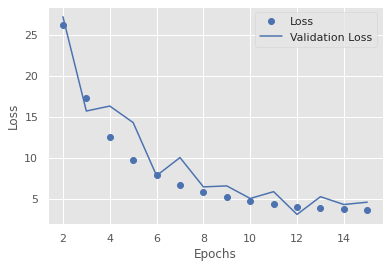

In [0]:
plt.style.use('ggplot')
plt.plot(epochs[1:], history_dict['loss'][1:], 'bo', 
         label='Loss')
plt.plot(epochs[1:], history_dict['val_loss'][1:], 'b',
         label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

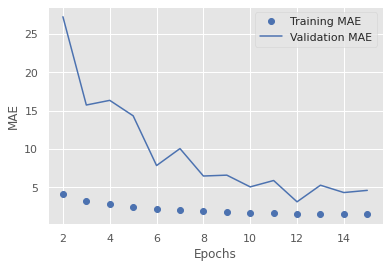

In [0]:
plt.clf()
mae_values = history_dict['mae']
val_mae_values = history_dict['val_loss']

plt.plot(epochs[1:], mae_values[1:], 'bo', 
         label='Training MAE')
plt.plot(epochs[1:], val_mae_values[1:], 'b',
         label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend();

In [0]:
test_mse_score, test_mae_score = model.evaluate(Xe_std_test_merged, ye_test)

3594/3594 [==============================] - 0s 56us/step


In [0]:
test_mae_score

1.6786233186721802

### Model 3: ANN + dropout

Because we are adding dropout layers, we will have to increase the numbere of epochs

In [0]:
from keras import models, layers

In [0]:
from keras.layers import Dropout

In [0]:
model = models.Sequential()

In [0]:
model.add(layers.Dense(64, 
                       activation='relu',
                       input_shape=(Xe_std_train_merged.shape[1],)))
model.add(Dropout(0.2))
model.add(layers.Dense(32, 
                       activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(1))

In [0]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                6272      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 8,385
Trainable params: 8,385
Non-trainable params: 0
_________________________________________________________________


In [0]:
from keras import optimizers

In [0]:
model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['mae'])

In [0]:
x_val = Xe_std_train_merged[:Xe_std_train_merged.shape[0]//4]
x_train_1 = Xe_std_train_merged[Xe_std_train_merged.shape[0]//4:]

In [0]:
y_val = ye_train[:Xe_std_train_merged.shape[0]//4]
y_train_1 = ye_train[Xe_std_train_merged.shape[0]//4:]

In [0]:
history = model.fit(x_train_1,
                    y_train_1,
                    epochs=50,
                    batch_size=5,
                    validation_data=(x_val, y_val))

Train on 6288 samples, validate on 2096 samples
Epoch 1/50
6288/6288 [==============================] - 4s 587us/step - loss: 475.3991 - mae: 15.2389 - val_loss: 43.3264 - val_mae: 5.2421
Epoch 2/50
6288/6288 [==============================] - 4s 574us/step - loss: 142.5513 - mae: 9.5161 - val_loss: 41.6777 - val_mae: 5.1343
Epoch 3/50
6288/6288 [==============================] - 4s 579us/step - loss: 127.6043 - mae: 9.0566 - val_loss: 34.1390 - val_mae: 4.6903
Epoch 4/50
6288/6288 [==============================] - 4s 581us/step - loss: 120.0585 - mae: 8.7101 - val_loss: 28.5916 - val_mae: 4.2441
Epoch 5/50
6288/6288 [==============================] - 4s 575us/step - loss: 112.8211 - mae: 8.4960 - val_loss: 31.9565 - val_mae: 4.5717
Epoch 6/50
6288/6288 [==============================] - 4s 584us/step - loss: 113.2716 - mae: 8.5088 - val_loss: 24.9571 - val_mae: 3.9226
Epoch 7/50
6288/6288 [==============================] - 4s 574us/step - loss: 107.1744 - mae: 8.2347 - val_loss: 18.1

In [0]:
history_dict = history.history

In [0]:
epochs = range(1, len(history_dict['mae']) + 1)

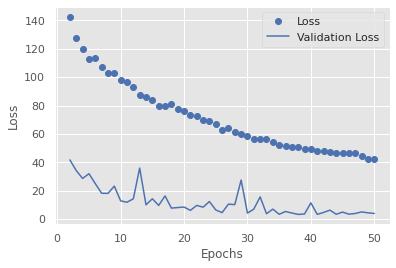

In [0]:
plt.style.use('ggplot')
plt.plot(epochs[1:], history_dict['loss'][1:], 'bo', 
         label='Loss')
plt.plot(epochs[1:], history_dict['val_loss'][1:], 'b',
         label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

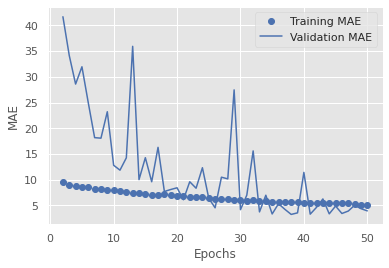

In [0]:
plt.clf()
mae_values = history_dict['mae']
val_mae_values = history_dict['val_loss']

plt.plot(epochs[1:], mae_values[1:], 'bo', 
         label='Training MAE')
plt.plot(epochs[1:], val_mae_values[1:], 'b',
         label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend();

In [0]:
test_mse_score, test_mae_score = model.evaluate(Xe_std_test_merged, ye_test)

3594/3594 [==============================] - 0s 45us/step


In [0]:
test_mae_score

1.4121708869934082